### Imports

In [7]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

## Data collection

In [19]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_11814/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [20]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[*********************100%***********************]  504 of 504 completed

4 Failed downloads:
['HON']: Timeout('Failed to perform, curl: (28) Operation timed out after 10563 milliseconds with 235479 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['GE']: Timeout('Failed to perform, curl: (28) Operation timed out after 10447 milliseconds with 219612 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [21]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [2]:
data = pd.read_parquet("data/SPY_data.pq")

In [3]:
selected_stocks = data['Close'].columns.unique()[(data['Close'].isna().mean()<0.1)]

In [4]:
len(selected_stocks)

369

In [5]:
data.columns.get_level_values(0).unique()

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [6]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [7]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [8]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()

In [15]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,dollar_volume,share_dollar_volume,body_ratio,turnover_proxy,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,
2025-11-24,XEL,73.783110,-79.705079,1.254567,-70.515747,21.364230,-4.616487,131.688495,-77.893140,6340300.0,5.071289e+08,0.001348,0.009527,0.313411,22.618797,-75.132233
2025-11-24,XOM,-95.259300,-248.747489,7.690347,-64.079967,-2.563889,-28.544605,148.481099,-61.100537,18034900.0,2.102599e+09,0.005520,0.051793,1.885965,5.126458,-92.624573
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,5.535747e+08,0.000870,0.884709,0.382612,249.524614,151.773584
2025-11-24,ZBH,144.320907,-9.167282,297.280165,225.509851,45.926001,19.945284,398.187759,188.606124,2779100.0,2.594290e+08,0.000899,0.746583,0.238439,343.206166,245.455135
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,2.251958e+08,0.000402,0.670614,0.277766,534.909794,437.158763


In [16]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

# Feature list
1. Avg past returns close to close
2. Avg past returns open to close
3. Avg past returns low to close
4. Avg past returns high to low

- Hedged/Not hedged
- Clipped/Not clipped

# Models list

## Baseline
1. Random
2. Past returns (define period)
3. MACD vol adjusted
4. Linear Regression (define features + beta)

## LTR
1. LambdaMART (pairwise)
2. LambdaRANK (listwise)
3. ListMLE (listwise - use LightGBM)

# Baseline models

## Random Strategy

In [10]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)


In [11]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']).mean())

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

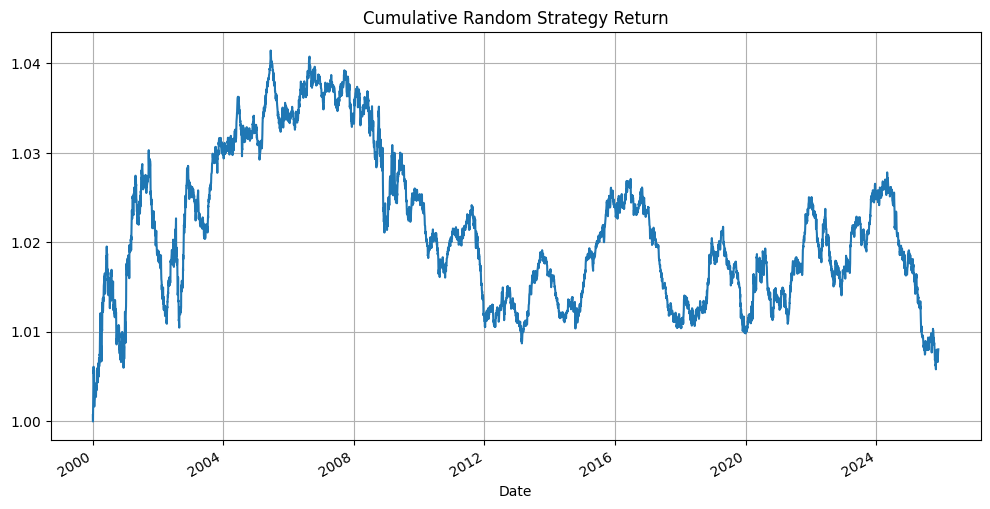

In [12]:
(random_daily_returns.cumsum()*1e-4+1).plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [13]:
random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252)

np.float64(0.04475120341085754)

## Momentum Strategies

### Simple Momentum Strategy

In [14]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: 1 if y == 0 else (-1 if y == 9 else 0))
    return signal

In [15]:
df['momentum_hedged_signal'] = df.groupby('Date')['close_1d_ret_hedged'].transform(compute_signal)

In [16]:
df['momentum_hedged_signal'] = df.groupby('Ticker')['momentum_hedged_signal'].shift()

In [17]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret'].transform(compute_signal)

In [18]:
df['momentum_signal'] = df.groupby('Ticker')['momentum_signal'].shift()

In [19]:
momentum_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'hedged': (x['momentum_hedged_signal'] * x['close_1d_ret']).mean(),
        'unhedged': (x['momentum_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

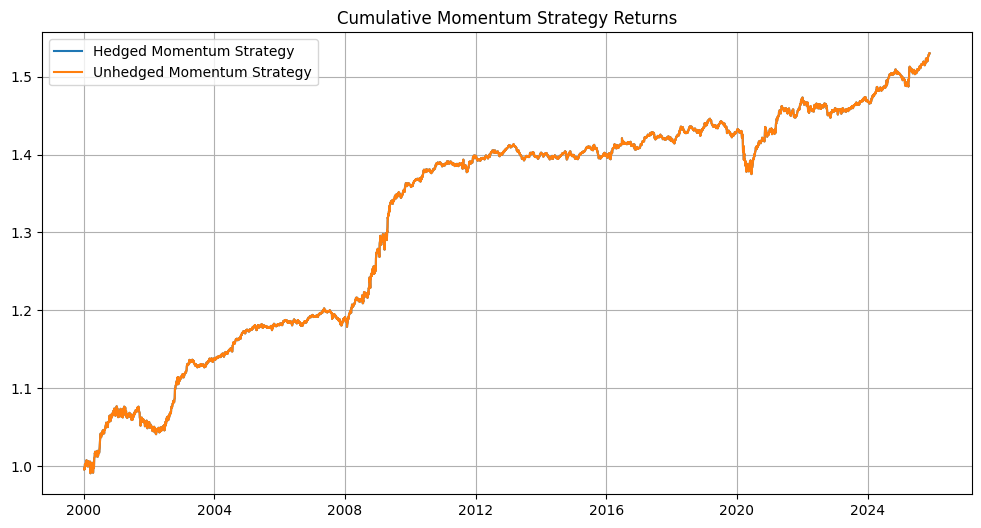

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(momentum_daily_returns['hedged'].cumsum() + 1, label='Hedged Momentum Strategy')
plt.plot(momentum_daily_returns['unhedged'].cumsum() + 1, label='Unhedged Momentum Strategy')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252)

hedged      0.981067
unhedged    0.981067
dtype: float64

### MACD Vol adjusted Strategy

In [22]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [23]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [24]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [25]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [26]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [27]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [28]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret']).mean(),
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret']).mean()
    })
)*1e-4

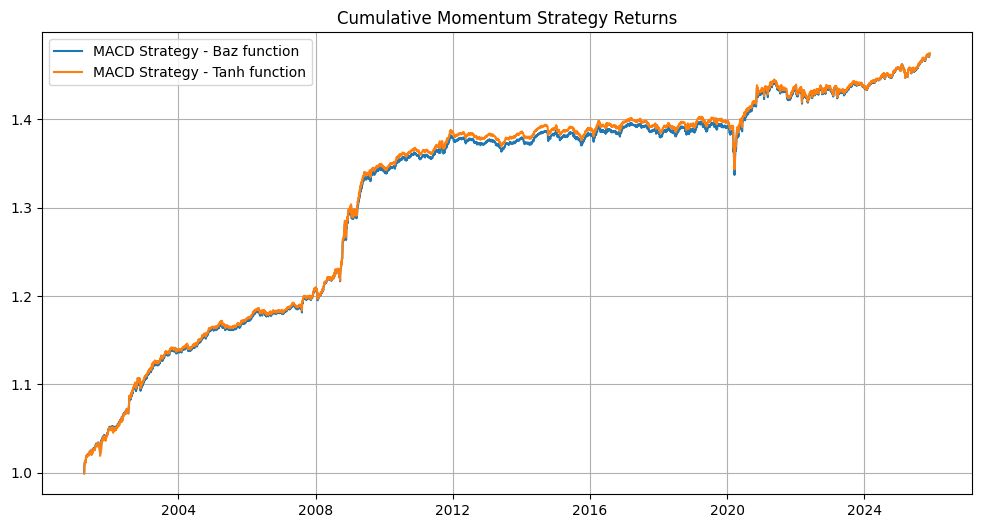

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(macd_daily_returns['baz'].cumsum() + 1, label='MACD Strategy - Baz function')
plt.plot(macd_daily_returns['tanh'].cumsum() + 1, label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
macd_daily_returns.mean()/macd_daily_returns.std()*np.sqrt(252)

baz     1.130381
tanh    1.130951
dtype: float64

# Regress-then-rank Strategies 

## Linear Regression

### Feature factory

In [17]:
def daily_metrics(group, feature, target, beta_global):
    reg = LinearRegression(fit_intercept=False)
    if len(group) < 2:
        return pd.Series({'beta': np.nan, 'bias': np.nan})
    reg.fit(group[[feature]], group[target])
    predictions = reg.predict(group[[feature]])
    bias = np.std(predictions)
    if reg.coef_[0]*beta_global < 0:
        bias *= -1
    return pd.Series({'bias': bias})

In [18]:
def single_feature_metrics(df, feature, target, drop_extreme_perc=True, ts_bool=False, fit_intercept=False):
    global_reg = LinearRegression(fit_intercept=fit_intercept)
    if drop_extreme_perc:
        first_perc, last_perc = np.percentile(df[feature].dropna(), [1, 99])
        df_filtered = df[(df[feature]>=first_perc) & (df[feature]<=last_perc)]
    else:
        df_filtered = df.copy(deep=True)
    global_reg.fit(df_filtered[[feature]], df_filtered[target])
    predictions = global_reg.predict(df_filtered[[feature]])
    bias = np.std(predictions)
    stab = (predictions * df_filtered[target] > 0).mean() * 100
    beta_global = global_reg.coef_[0]
    if ts_bool:
        bias_ts = df_filtered.groupby('Date').apply(lambda x: daily_metrics(x, feature, target, beta_global))
        mean_bias_ts = bias_ts['bias'].mean()
        sharpe_ts = bias_ts['bias'].mean() / bias_ts['bias'].std() * np.sqrt(252)
        return bias, mean_bias_ts, stab, beta_global, sharpe_ts, bias_ts
    else:
        return bias, stab, beta_global

In [19]:
linear_features

['close_1d_ret_lag1',
 'close_1d_ret_hedged_lag1',
 'open_close_ret',
 'open_close_ret_hedged',
 'close_open_ret',
 'close_open_ret_hedged',
 'high_low_ret',
 'high_low_ret_hedged',
 'body_ratio']

In [20]:
all_linear_features = copy.deepcopy(linear_features)

In [21]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:48<00:39,  9.83s/it]/tmp/ipykernel_156723/3370916634.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
/tmp/ipykernel_156723/3370916634.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'zscore_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
/tmp/ipykernel_156723/3370916634.py:3: PerformanceWarning: DataFrame is highly fragmented.  T

In [29]:
dict_results = {'feature': [], 'bias': [], 'mean_bias_ts': [], 'stability': [], 'beta': [], 'sharpe_ts': [], 'bias_ts': []}
for feature in tqdm(all_linear_features):
    bias, mean_bias_ts, stability, beta, sharpe_ts, bias_ts = single_feature_metrics(df, feature, 'close_1d_ret', ts_bool=True)
    dict_results['feature'].append(feature)
    dict_results['bias'].append(bias)
    dict_results['mean_bias_ts'].append(mean_bias_ts)
    dict_results['stability'].append(stability)
    dict_results['beta'].append(beta)
    dict_results['sharpe_ts'].append(sharpe_ts)
    dict_results['bias_ts'].append(bias_ts)

100%|██████████| 153/153 [1:03:22<00:00, 24.85s/it]


In [31]:
import pickle

In [32]:
with open("dict_results.pkl", "wb") as f:
    pickle.dump(dict_results, f)

# Here

In [ ]:
results_df = pd.DataFrame(dict_results)

In [65]:
for h in [3, 5, 10, 20, 50, 100]:
    for clip in [100, 200, 300, 400]:
        df[f'avg_ret_hedged_{h}d_clip{clip}'] = df[f'avg_ret_hedged_{h}d'].clip(-clip, clip)

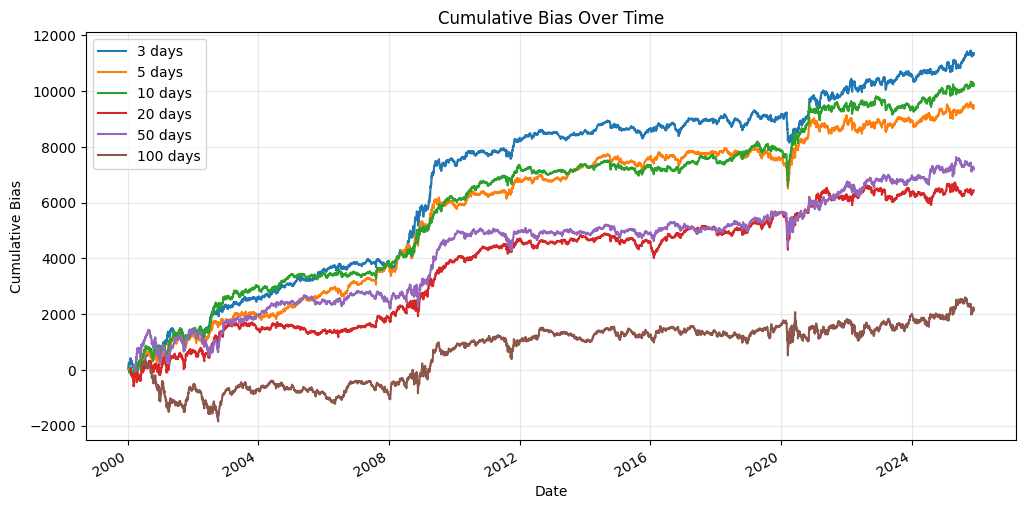

In [ ]:
plt.figure(figsize=(12, 6))
for h in dict_results['avg_ret_hedged'].keys():
    dict_results['avg_ret_hedged'][h][-1]['bias'].cumsum().plot(label=f'{h} days')
plt.legend()
plt.title('Cumulative Bias Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Bias')
plt.grid(True, alpha=0.3)
plt.show()